In [1]:
#1
import sys
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("../src"))
from NeuralNet import NeuralNet

In [2]:
#2
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
fuelCon = pd.read_csv("../data/FuelConsumptionCo2.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("FuelCon shape:", fuelCon.shape)


Train shape: (19237, 18)
Test shape: (8245, 18)
FuelCon shape: (1067, 13)


In [3]:
#3
print(fuelCon.head())


   MODELYEAR   MAKE       MODEL VEHICLECLASS  ENGINESIZE  CYLINDERS  \
0       2014  ACURA         ILX      COMPACT         2.0          4   
1       2014  ACURA         ILX      COMPACT         2.4          4   
2       2014  ACURA  ILX HYBRID      COMPACT         1.5          4   
3       2014  ACURA     MDX 4WD  SUV - SMALL         3.5          6   
4       2014  ACURA     RDX AWD  SUV - SMALL         3.5          6   

  TRANSMISSION FUELTYPE  FUELCONSUMPTION_CITY  FUELCONSUMPTION_HWY  \
0          AS5        Z                   9.9                  6.7   
1           M6        Z                  11.2                  7.7   
2          AV7        Z                   6.0                  5.8   
3          AS6        Z                  12.7                  9.1   
4          AS6        Z                  12.1                  8.7   

   FUELCONSUMPTION_COMB  FUELCONSUMPTION_COMB_MPG  CO2EMISSIONS  
0                   8.5                        33           196  
1                   

In [4]:
#4
cat_cols = ['MAKE', 'MODEL', 'VEHICLECLASS', 'TRANSMISSION', 'FUELTYPE']
num_cols = [
    'MODELYEAR', 'ENGINESIZE', 'CYLINDERS',
    'FUELCONSUMPTION_CITY', 'FUELCONSUMPTION_HWY',
    'FUELCONSUMPTION_COMB', 'FUELCONSUMPTION_COMB_MPG'
]



In [5]:
#5
y = fuelCon['CO2EMISSIONS'].values.reshape(-1,1).astype(float)

y_mean = y.mean()
y_std = y.std()
y_norm = (y - y_mean) / y_std



In [6]:
#6
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

X = preprocessor.fit_transform(fuelCon)



In [7]:
#7
idx = np.arange(X.shape[0])
np.random.shuffle(idx)
X, y_norm = X[idx], y_norm[idx]
y = y[idx]  


In [8]:
#8
if hasattr(X, "toarray"):
    X = X.toarray()


In [9]:
#9
input_size = X.shape[1]

nn = NeuralNet(
    n_layers=3,
    n_units=[input_size, 20, 1],
    epochs=50,
    lr=0.001,
    momentum=0.8,
    activation='sigmoid',
    val_percent=0.2
)

nn.fit(X, y_norm)
y_pred_norm = nn.predict(X)
y_pred = y_pred_norm * y_std + y_mean


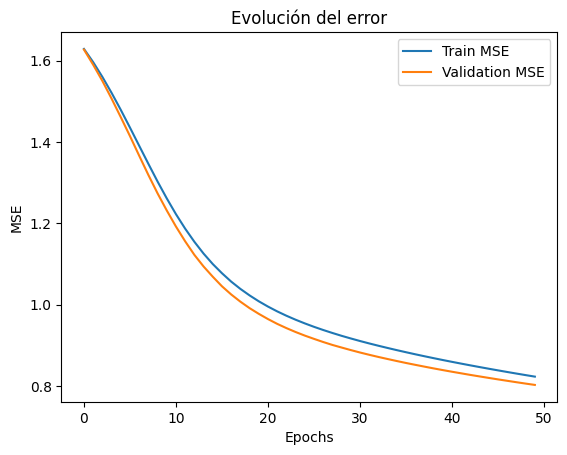

Último error (train, val): [0.82282118 0.80241782]


In [10]:
#10
loss = nn.loss_epochs()
plt.plot(loss[:,0], label='Train MSE')
plt.plot(loss[:,1], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Evolución del error')
plt.legend()
plt.show()

print("Último error (train, val):", loss[-1])


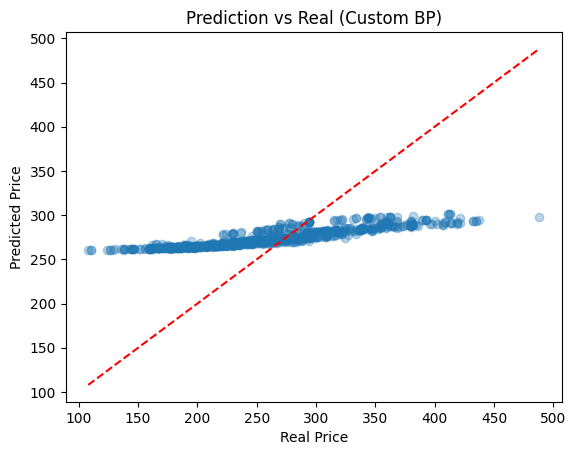

In [11]:
#11
plt.scatter(y, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.title('Prediction vs Real (Custom BP)')
plt.show()


In [12]:
#12
param_grid = [
    {"layers": 3, "units": [input_size, 10, 1], "lr": 0.01, "momentum": 0.5, "act": "sigmoid"},
    {"layers": 3, "units": [input_size, 20, 1], "lr": 0.01, "momentum": 0.9, "act": "sigmoid"},
    {"layers": 3, "units": [input_size, 30, 1], "lr": 0.005, "momentum": 0.8, "act": "tanh"},
    {"layers": 3, "units": [input_size, 50, 1], "lr": 0.001, "momentum": 0.9, "act": "relu"},
    {"layers": 4, "units": [input_size, 32, 16, 1], "lr": 0.01, "momentum": 0.7, "act": "sigmoid"},
    {"layers": 4, "units": [input_size, 64, 32, 1], "lr": 0.005, "momentum": 0.8, "act": "tanh"},
    {"layers": 3, "units": [input_size, 16, 1], "lr": 0.02, "momentum": 0.5, "act": "sigmoid"},
    {"layers": 3, "units": [input_size, 40, 1], "lr": 0.002, "momentum": 0.9, "act": "tanh"},
    {"layers": 3, "units": [input_size, 25, 1], "lr": 0.01, "momentum": 0.9, "act": "relu"},
    {"layers": 4, "units": [input_size, 32, 16, 1], "lr": 0.001, "momentum": 0.8, "act": "linear"}
]



In [13]:
#13
results = []
best_mse = float('inf')
best_preds = None
best_params = None
best_loss_curve = None

for i, params in enumerate(param_grid):
    print(f"\n🔎 Training model {i+1}/{len(param_grid)} with params: {params}")
    
    nn = NeuralNet(
        n_layers=params["layers"],
        n_units=params["units"],
        epochs=50,
        lr=params["lr"],
        momentum=params["momentum"],
        activation=params["act"],
        val_percent=0.2
    )

    nn.fit(X, y_norm)
    loss_curve = nn.loss_epochs()
    
    y_pred_norm = nn.predict(X)
    y_pred = y_pred_norm * y_std + y_mean

    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    mape = np.mean(np.abs((y - y_pred) / y)) * 100

    results.append({
        "Layers": params["layers"],
        "Structure": str(params["units"]),
        "LR": params["lr"],
        "Momentum": params["momentum"],
        "Act": params["act"],
        "MSE": mse,
        "MAE": mae,
        "MAPE": mape,
        "Loss": loss_curve
    })

    if mse < best_mse:
        best_mse = mse
        best_preds = y_pred
        best_params = params
        best_loss_curve = loss_curve
    
    print(f" → MSE: {mse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")



🔎 Training model 1/10 with params: {'layers': 3, 'units': [751, 10, 1], 'lr': 0.01, 'momentum': 0.5, 'act': 'sigmoid'}
 → MSE: 2638.51, MAE: 41.31, MAPE: 24.97%

🔎 Training model 2/10 with params: {'layers': 3, 'units': [751, 20, 1], 'lr': 0.01, 'momentum': 0.9, 'act': 'sigmoid'}
 → MSE: 2350.57, MAE: 37.84, MAPE: 25.58%

🔎 Training model 3/10 with params: {'layers': 3, 'units': [751, 30, 1], 'lr': 0.005, 'momentum': 0.8, 'act': 'tanh'}
 → MSE: 682.70, MAE: 16.13, MAPE: 25.68%

🔎 Training model 4/10 with params: {'layers': 3, 'units': [751, 50, 1], 'lr': 0.001, 'momentum': 0.9, 'act': 'relu'}
 → MSE: 1766.56, MAE: 29.85, MAPE: 27.64%

🔎 Training model 5/10 with params: {'layers': 4, 'units': [751, 32, 16, 1], 'lr': 0.01, 'momentum': 0.7, 'act': 'sigmoid'}
 → MSE: 3039.89, MAE: 45.14, MAPE: 24.19%

🔎 Training model 6/10 with params: {'layers': 4, 'units': [751, 64, 32, 1], 'lr': 0.005, 'momentum': 0.8, 'act': 'tanh'}
 → MSE: 656.67, MAE: 15.44, MAPE: 25.74%

🔎 Training model 7/10 with 

In [14]:
#14
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("MSE").reset_index(drop=True)
df_results


,Layers,Structure,LR,Momentum,Act,MSE,MAE,MAPE,Loss
0,4,"[751, 32, 16, 1]",0.001,0.8,linear,117.469585,8.421942,29.281858,"[[0.42712003042428365, 0.17319016393366007], [..."
1,4,"[751, 64, 32, 1]",0.005,0.8,tanh,656.671471,15.441364,25.743051,"[[0.2656684256356597, 0.23940506660670643], [0..."
2,3,"[751, 30, 1]",0.005,0.8,tanh,682.697272,16.126515,25.683186,"[[0.33742666304296537, 0.17344725471187708], [..."
3,3,"[751, 40, 1]",0.002,0.9,tanh,724.508073,17.110420,25.711259,"[[0.47817304961460133, 0.1944354621368327], [0..."
4,3,"[751, 25, 1]",0.010,0.9,relu,1704.163039,26.983468,27.789504,"[[0.594895780167714, 0.5056440265588169], [0.4..."
5,3,"[751, 50, 1]",0.001,0.9,relu,1766.564078,29.850913,27.642257,"[[0.8390809800369089, 0.693558070078573], [0.5..."
6,3,"[751, 20, 1]",0.010,0.9,sigmoid,2350.565809,37.844117,25.580826,"[[1.1049795039960175, 0.8586278721418255], [0...."
7,3,"[751, 16, 1]",0.020,0.5,sigmoid,2424.067574,38.961615,25.294009,"[[1.5446570291773578, 1.3780348486967626], [1...."
8,3,"[751, 10, 1]",0.010,0.5,sigmoid,2638.508732,41.312855,24.966075,"[[1.4050976844505942, 1.3793829674197524], [1...."
9,4,"[751, 32, 16, 1]",0.010,0.7,sigmoid,3039.886469,45.140062,24.186331,"[[1.5653203313128863, 1.460422919520592], [1.3..."


In [15]:
#15
best_idx = df_results["MSE"].idxmin()
best_model = df_results.iloc[best_idx]
best_model


Layers                                                       4
Structure                                     [751, 32, 16, 1]
LR                                                       0.001
Momentum                                                   0.8
Act                                                     linear
MSE                                                 117.469585
MAE                                                   8.421942
MAPE                                                 29.281858
Loss         [[0.42712003042428365, 0.17319016393366007], [...
Name: 0, dtype: object

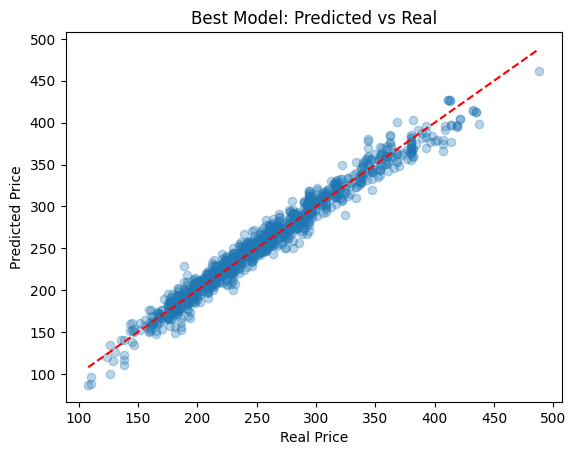

In [16]:
#16
plt.scatter(y, best_preds, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Real Price")
plt.ylabel("Predicted Price")
plt.title("Best Model: Predicted vs Real")
plt.show()


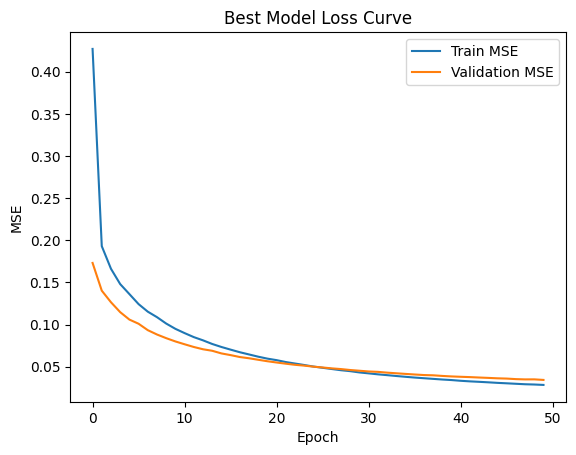

In [17]:
#17
loss = best_loss_curve
plt.plot(loss[:,0], label='Train MSE')
plt.plot(loss[:,1], label='Validation MSE')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.title("Best Model Loss Curve")
plt.show()


In [18]:
#18
print("y first 10 values:\n", y[:10])
print("y shape:", y.shape)
print("min:", y.min(), "max:", y.max())
print("mean:", y.mean(), "std:", y.std())


y first 10 values:
 [[163.]
 [196.]
 [230.]
 [184.]
 [409.]
 [253.]
 [380.]
 [318.]
 [260.]
 [274.]]
y shape: (1067, 1)
min: 108.0 max: 488.0
mean: 256.2286785379569 std: 63.34260099404253
